In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import pandas

In [2]:
def def_cmap(color):
    colors = ["white", color]
    n_bins = 100
    cmap_name = "cmap"
    self_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return self_cmap

# Tracking Code for separate tracking in different time interval

## Plot the pseudo tracks in the vector field coordinate without rescaling.

In [9]:
x_track = []
y_track = []
t_track = []

file_name = "track_vector_field_cor_2"

def decode(elem):
    return elem.decode("UTF-8")

with h5py.File(file_name, "r") as file:
    track_id = (list(map(decode, file["track_id"][:])))

for i in track_id:
    with h5py.File(file_name, "r") as file:
        x_track.append(file["x_track_"+str(i)][:])
        y_track.append(file["y_track_"+str(i)][:])
        t_track.append(file["t_track_"+str(i)][:])

# with h5py.File("start_points.h5", "r") as file:
#     track_id = (list(map(decode, file["track_id"][:])))
#     start_x_cor = file["start_x"][:]
#     start_y_cor = file["start_y"][:]
#     start_t = file["t_interval"][:]

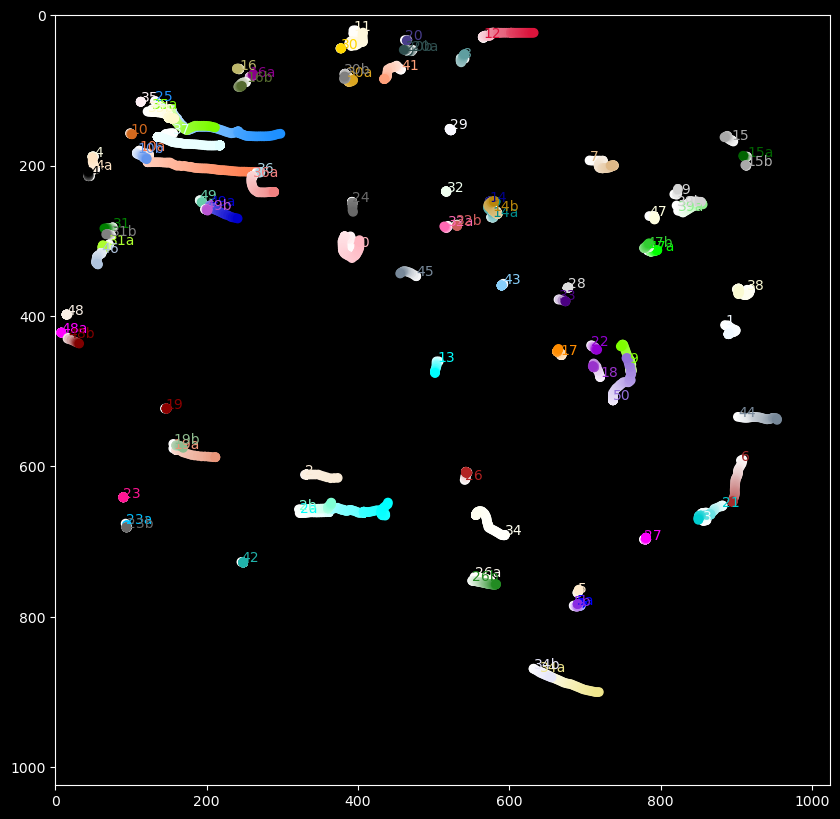

In [11]:
plt.style.use('dark_background')
#colors = ["gray", "mediumpurple", "deepskyblue", "orange", "red", "darkseagreen", "hotpink", "peru", "olivedrab", "turquoise"]
colors = list(mcolors.CSS4_COLORS.keys())

# piv_x_track = []
# piv_y_track = []

plt.figure(figsize=(10, 10))
for i in range(len(track_id)):
    
    x_cor = x_track[i]
    y_cor = y_track[i]
    t_interval = range(t_track[i][0], t_track[i][-1]+1)
    
    plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
    cmap = def_cmap(colors[i])
    plt.scatter(x_cor, y_cor, c=t_interval, zorder=2, cmap=cmap)
    plt.annotate(str(track_id[i]), xy = (x_cor[0], y_cor[0]), c=colors[i])

    # piv_x_track.append(x_cor)
    # piv_y_track.append(y_cor)

plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.gca().invert_yaxis()
#plt.savefig("pseudotrack_vector_field_cor", dpi=300)
plt.show()

## Plot the original tracking data

In [4]:
# Read csv file.
track_csv = pandas.read_csv("F:/PhD_Franziska/Headon/Headon_results/v1_slice3/video1_tracking_cleaned.csv")

In [5]:
# Extract all starting positions, start frame and end frame of tracks. Build up a new dataframe.

all_track_id = track_csv["Track"].unique().tolist() # List of string.
all_start_x_cor = []
all_start_y_cor = []
all_t = []

for i in all_track_id:
    single_track = track_csv.loc[track_csv["Track"] == i]
    all_start_x_cor.append([single_track.iloc[0]["X"]]) # List of one element lists
    all_start_y_cor.append([single_track.iloc[0]["Y"]]) # list of one element lists
    all_t.append([single_track.iloc[0]["Frame"], single_track.iloc[-1]["Frame"]]) # List of two element lists

# Store the data into h5 files for processing with Julia script.
    
# start_track = h5py.File("start_points.h5", "w")
# start_track.create_dataset("track_id", data = all_track_id)
# start_track.create_dataset("start_x", data = all_start_x_cor)
# start_track.create_dataset("start_y", data = all_start_y_cor)
# start_track.create_dataset("t_interval", data = all_t)
# start_track.close()

In [9]:
# def decode(elem):
#     return elem.decode("UTF-8")

# with h5py.File("start_points.h5", "r") as file:
#     track_id = (list(map(decode, file["track_id"][:])))
#     start_x_cor = file["start_x"][:]
#     start_y_cor = file["start_y"][:]
#     start_t = file["t_interval"][:]

In [18]:
# Extract certain tracks with given track_ids
track_id = all_track_id

original_x_track = []
original_y_track = []
original_t_track = []

for i in track_id:
    o_x = track_csv.loc[track_csv["Track"]==str(i)]["X"].tolist()
    o_y = track_csv.loc[track_csv["Track"]==str(i)]["Y"].tolist()
    o_t = track_csv.loc[track_csv["Track"]==str(i)]["Frame"].tolist()
    original_x_track.append(o_x)
    original_y_track.append(o_y)
    original_t_track.append(o_t)

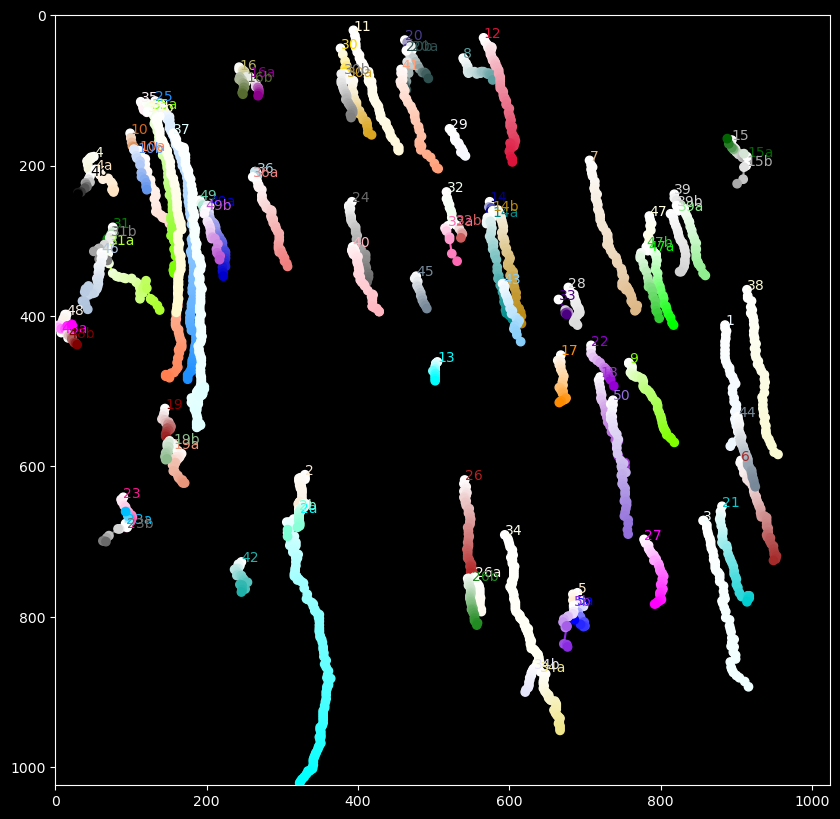

In [21]:
# Track plots

plt.style.use('dark_background')
#colors = ["gray", "mediumpurple", "deepskyblue", "orange", "red", "darkseagreen", "hotpink", "peru", "olivedrab", "turquoise"]
colors = list(mcolors.CSS4_COLORS.keys())

plt.figure(figsize=(10, 10))
for i in range(len(track_id)):
    x_cor = original_x_track[i]
    y_cor = original_y_track[i]
    t_interval = original_t_track[i]
    plt.plot(x_cor, y_cor, color=colors[i], zorder=1)
    cmap = def_cmap(colors[i])
    plt.scatter(x_cor, y_cor, c=t_interval, zorder=2, cmap=cmap)
    plt.annotate(str(track_id[i]), xy = (x_cor[0], y_cor[0]), c=colors[i])

plt.xlim(0, 1024)
plt.ylim(0, 1024)
plt.gca().invert_yaxis()
plt.savefig("all_tracking_video_1_periderm", dpi = 300)
plt.show()

# Velocity profile of tracks (so far only original tracks)

In [69]:
# Calculate the velocity profile from the original tracking data.

all_move = []

# Calculate the dictance between neighbour pair positions (step width) in each track.
for i in all_track_id:
    x_y = track_csv.loc[track_csv["Track"] == str(i)][["X", "Y"]].values.tolist() # Convert X and Y coordinate pairs into list of 2D lists. 
    diff = np.diff(x_y, axis = 0)
    norm = np.linalg.norm(diff, axis = 1)
    all_move.append(norm)

max_len = max(len(l) for l in all_move)

# Fill all track step witdth with nan to the same length --> (#track, maxi_time) dimensional array.
for j in range(len(all_track_id)):
    move = all_move[j]
    num_zero = max_len - len(move)
    all_move[j] = np.concatenate([move, np.full(num_zero, np.nan)]) # Fill with nan.

all_move = np.stack(all_move)
num_step = np.shape(all_move)[1]

# Add the step widths columnwise --> get the mean step width at aech time step.
step_width_per_time = []
mean_per_time = np.zeros(num_step)
std_per_time = np.zeros(num_step)

for k in range(num_step):
    step = all_move[:, k]
    track = step[~np.isnan(step)] # Get rid of the nan in coloums. 
    step_width_per_time.append(track)
    mean_per_time[k] = np.mean(track)
    std_per_time[k] = np.std(track)

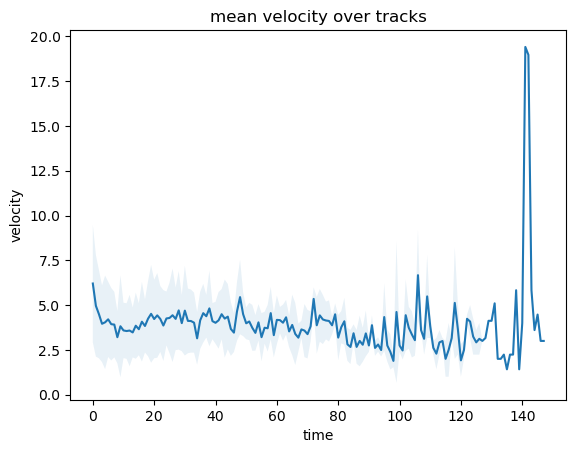

In [73]:
plt.title("mean velocity over tracks")

plt.plot(range(num_step), mean_per_time)
plt.fill_between(range(num_step), mean_per_time-std_per_time, mean_per_time+std_per_time, alpha=0.1)
plt.xlabel("time")
plt.ylabel("velocity")
plt.savefig("mean_vel_tracking", dpi=300)